<h1 align="center"><font face = "Times New Roman" size = "80">JPEG Compression</font></h1>
<h2 align="center"><font face = "Times New Roman" size = ""> Information theory and coding</font></h2>
<h3 align="center"><font face = "Times New Roman"> Fall 2019</font></h3>
<h5 align="center"><font face = "Times New Roman"">Alaa Mohamed Roshdy&nbsp 201600031</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Adham Mahrous&nbsp 201601078</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Mostafa Hamed&nbsp 201600236</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Kasem Saber&nbsp 201601144</font></h5>




---




## Introduction

JPEG compression is one of the most frequently used form of lossy compression for images. In this paper, we implement JPEG and JPEG_2000 compression and compare different compression types together, computing their compression ratios, root mean square error, and number of FLOP operations for each compression.
For JPEG, we use 2 different block sizes for compression. Namely, 8x8 and 16x16. Furthermore, different quantization tables were used. Low quantization table ranges its values from 1-16, and high quantization table ranges its values from 1-256. 
For JPEG_2000, 2 different quantization arrays are used to quantize the DWT decomposed images. Also, DWT decomposition can be performed at an arbitrary depth of the image.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
from PIL import Image
from encoder import reshape_image
from encoder_2000 import check_image,dwt
import main as m
import main_2000 as m2

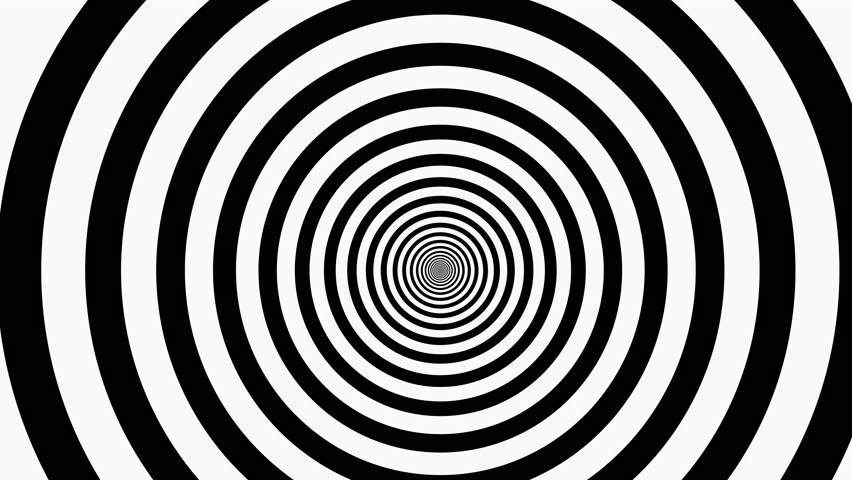

In [18]:
# Display the image

im = Image.open('images/contrast.jpg')
im = im.convert("L")
im

In [19]:
def rmse(im, reconstructed_image):
    """
    Gets the root mean squared error between 2 images
    Args:
         im (numpy array) : The original image
         reconstructed_image (numpy ndarray): The reconstructed image
    Returns:
        rmse: root mean squared error as a metric to compare between the original image and the reconstructed
    """
    error = im - reconstructed_image
    mse = np.sum(np.square(error)) / (im.shape[0] * im.shape[1])
    rmse = np.sqrt(mse)

    return rmse




---


<h1 align="center"><font face = "Times New Roman">JPEG compression</font></h1>


## Methodology

In the following 4 blocks of code, we repeatedly encode and decode the image according to the given block size and quantization table. The huffman encoded sequence is saved in *encoded* array to be later used in computing the compression ratio. All reconstructed images are saved in reconstructed array, and the execution time for each compression type is saved in *execution_time* array.

To encode and decode, 2 main functions in main.py were utilized; namely, encode() and decode(). Both functions arrange all encoder.py and decoder.py functions sequentially in the following way: 

![jpeg pipeline diagram](images/JPEG_diagram.png)

### Encoding

A PIL image is passed to a function where it is converted to grayscale and resized to the nearest dimensions divisible by 8. This is important since this image gets then divided into N subimages of sizes 8x8 or 16x16 depending on the input block size, and fractional numbers are not allowed for images. This resized image gets converted to a numpy array for easier computations. Each pixel is a value in the range 0-255. Then, DCT is applied on each of the N number of M x M arrays. Shown below is a gif of the DCT operation on a single 8x8 image block. Since this is 8x8 compression, there are 64 8x8 basis functions, each capturing a different frequency. The first basis function block is completely white which corresponds to the lowest frequency, and the last basis block has many small black and white boxes which correspond to the high frequency. Any image block is a combination of these basis functions. (This GIF is a snippet from Numberphile's video on JPEG compression. Link: https://www.youtube.com/watch?v=Q2aEzeMDHMA )  ![jpeg pipeline diagram](images/DCT.gif) </br>For the DCT operation, a helper function was generated to further speed up the process of compression. Instead of computing the basis functions (shown in the gif above as a checkerboard) for the DCT every single iteration on the image, the basis functions are computed only once and then used on all iterations thereafter on the image. This significantly lowered the computational time needed to compress the image. After that, one of 2 quantization tables gets used to quantize the DCT values. Quantization reduces the large DCT values that correspond to high frequencies in the image, which makes these values later encoded in lower number of bits. High compression is achieved by having large quantization values in the array. The 2D quantized array is then serialized and read in zigzag format to be represented in 1D array. Shown below is how the 2D array is read. (This GIF is a snippet from Numberphile's video on JPEG compression. Link: https://www.youtube.com/watch?v=Q2aEzeMDHMA )  ![jpeg pipeline diagram](images/serialization.gif) </br> Once done, we can see from the gif how there is a large number of repeated 0s in the whole array. These zeros can be reduced to a few bits using run-length encoding. Run-length encoding is performed on this 1D array to eliminate all the 0s, and then huffman encoding to further compress the data. The final result is a stream of bits represented in the form of string for convenience, and a dictionary for the huffman decoder to decode with.

### Decoding

The inverse of the process above is implemented. Using the given stream of bits and code dictionary, the data is decoded using huffman decoder, and then passed to the run-length decoder to decode the output. Then, the data is deserialized and returned to 2D arrays to be then dequantized. Dequantization is just multiplying each m x m block by the quantization array that was used in the quantization process. IDCT is then applied on each of the m x m image block and rearranged together to return a reconstructed image.


### Analysis

To measure the compression ratio for each image, the size of the image is computed in bits by multiplying the size of a single element in the array by the number of elements in the whole image. As for the encoded image, its size was computed by finding the length of the huffcoded string, since in reality, this string is a stream of bits, not a string. The size of the image is then divided by the stream of bits to compute the compression ratio. Moreover, the number of FLOPs was computed by calculating the time for the whole compression operation divided by the time for a single flop.

In [20]:
# Define block size
box_size = 8
encoded = [] # An array containing all 4 huffcodes resulting from the encoding process
reconstructed = [] # Array containing all 4 reconstructed images
execution_time = [] # Execution time for each compression

start = timeit.default_timer()
# Apply 8 x 8 compression using low compression quantization table

huffcoded, code_dict, n_rows, n_columns = m.encode(im, box_size, m.table_8_low)
encoded.append(huffcoded)
reconstructed.append( m.decode(huffcoded, code_dict,  n_rows, n_columns, box_size, m.table_8_low))
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[0])

Execution time:  36.548634309999215


In [21]:
box_size = 8

start = timeit.default_timer()
# Apply 8 x 8 compression using high compression quantization table

huffcoded, code_dict, n_rows, n_columns = m.encode(im, box_size, m.table_8_high)
encoded.append(huffcoded)
reconstructed.append( m.decode(huffcoded, code_dict,  n_rows, n_columns, box_size, m.table_8_high) )
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[1])

Execution time:  14.908032700000149


In [22]:
box_size = 16

start = timeit.default_timer()
# Apply 16 x 16 compression using low compression quantization table

huffcoded, code_dict, n_rows, n_columns = m.encode(im, box_size, m.table_16_low)
encoded.append(huffcoded)
reconstructed.append( m.decode(huffcoded, code_dict,  n_rows, n_columns, box_size, m.table_16_low))
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[2])

Execution time:  33.62885627600008


In [23]:
box_size = 16

start = timeit.default_timer()
# Apply 16 x 16 compression using high compression quantization table

huffcoded, code_dict, n_rows, n_columns = m.encode(im, box_size, m.table_16_high)
encoded.append(huffcoded)
reconstructed.append( m.decode(huffcoded, code_dict,  n_rows, n_columns, box_size, m.table_16_high))
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[3])

Execution time:  10.07035259300028




## Comparison
### Qualitative comparison



When zoomed in, we can see the clear difference between each resulting image, especially in edges with high contrast. 16x16 compression yields pixelated images that are clearer to see than 8x8 compression and larger in size. Furthermore, we can see clear difference between high compression and low compression in both block sizes. High compression yielded more 'noisy' image than low compression. In low compression, the difference between 8x8 compression and 16x16 is not visible by just perceiving the image. However, in high compression, the quality is visibly lower in 16x16 than 8x8.

Text(0.5, 1.0, '16x16 high compression')

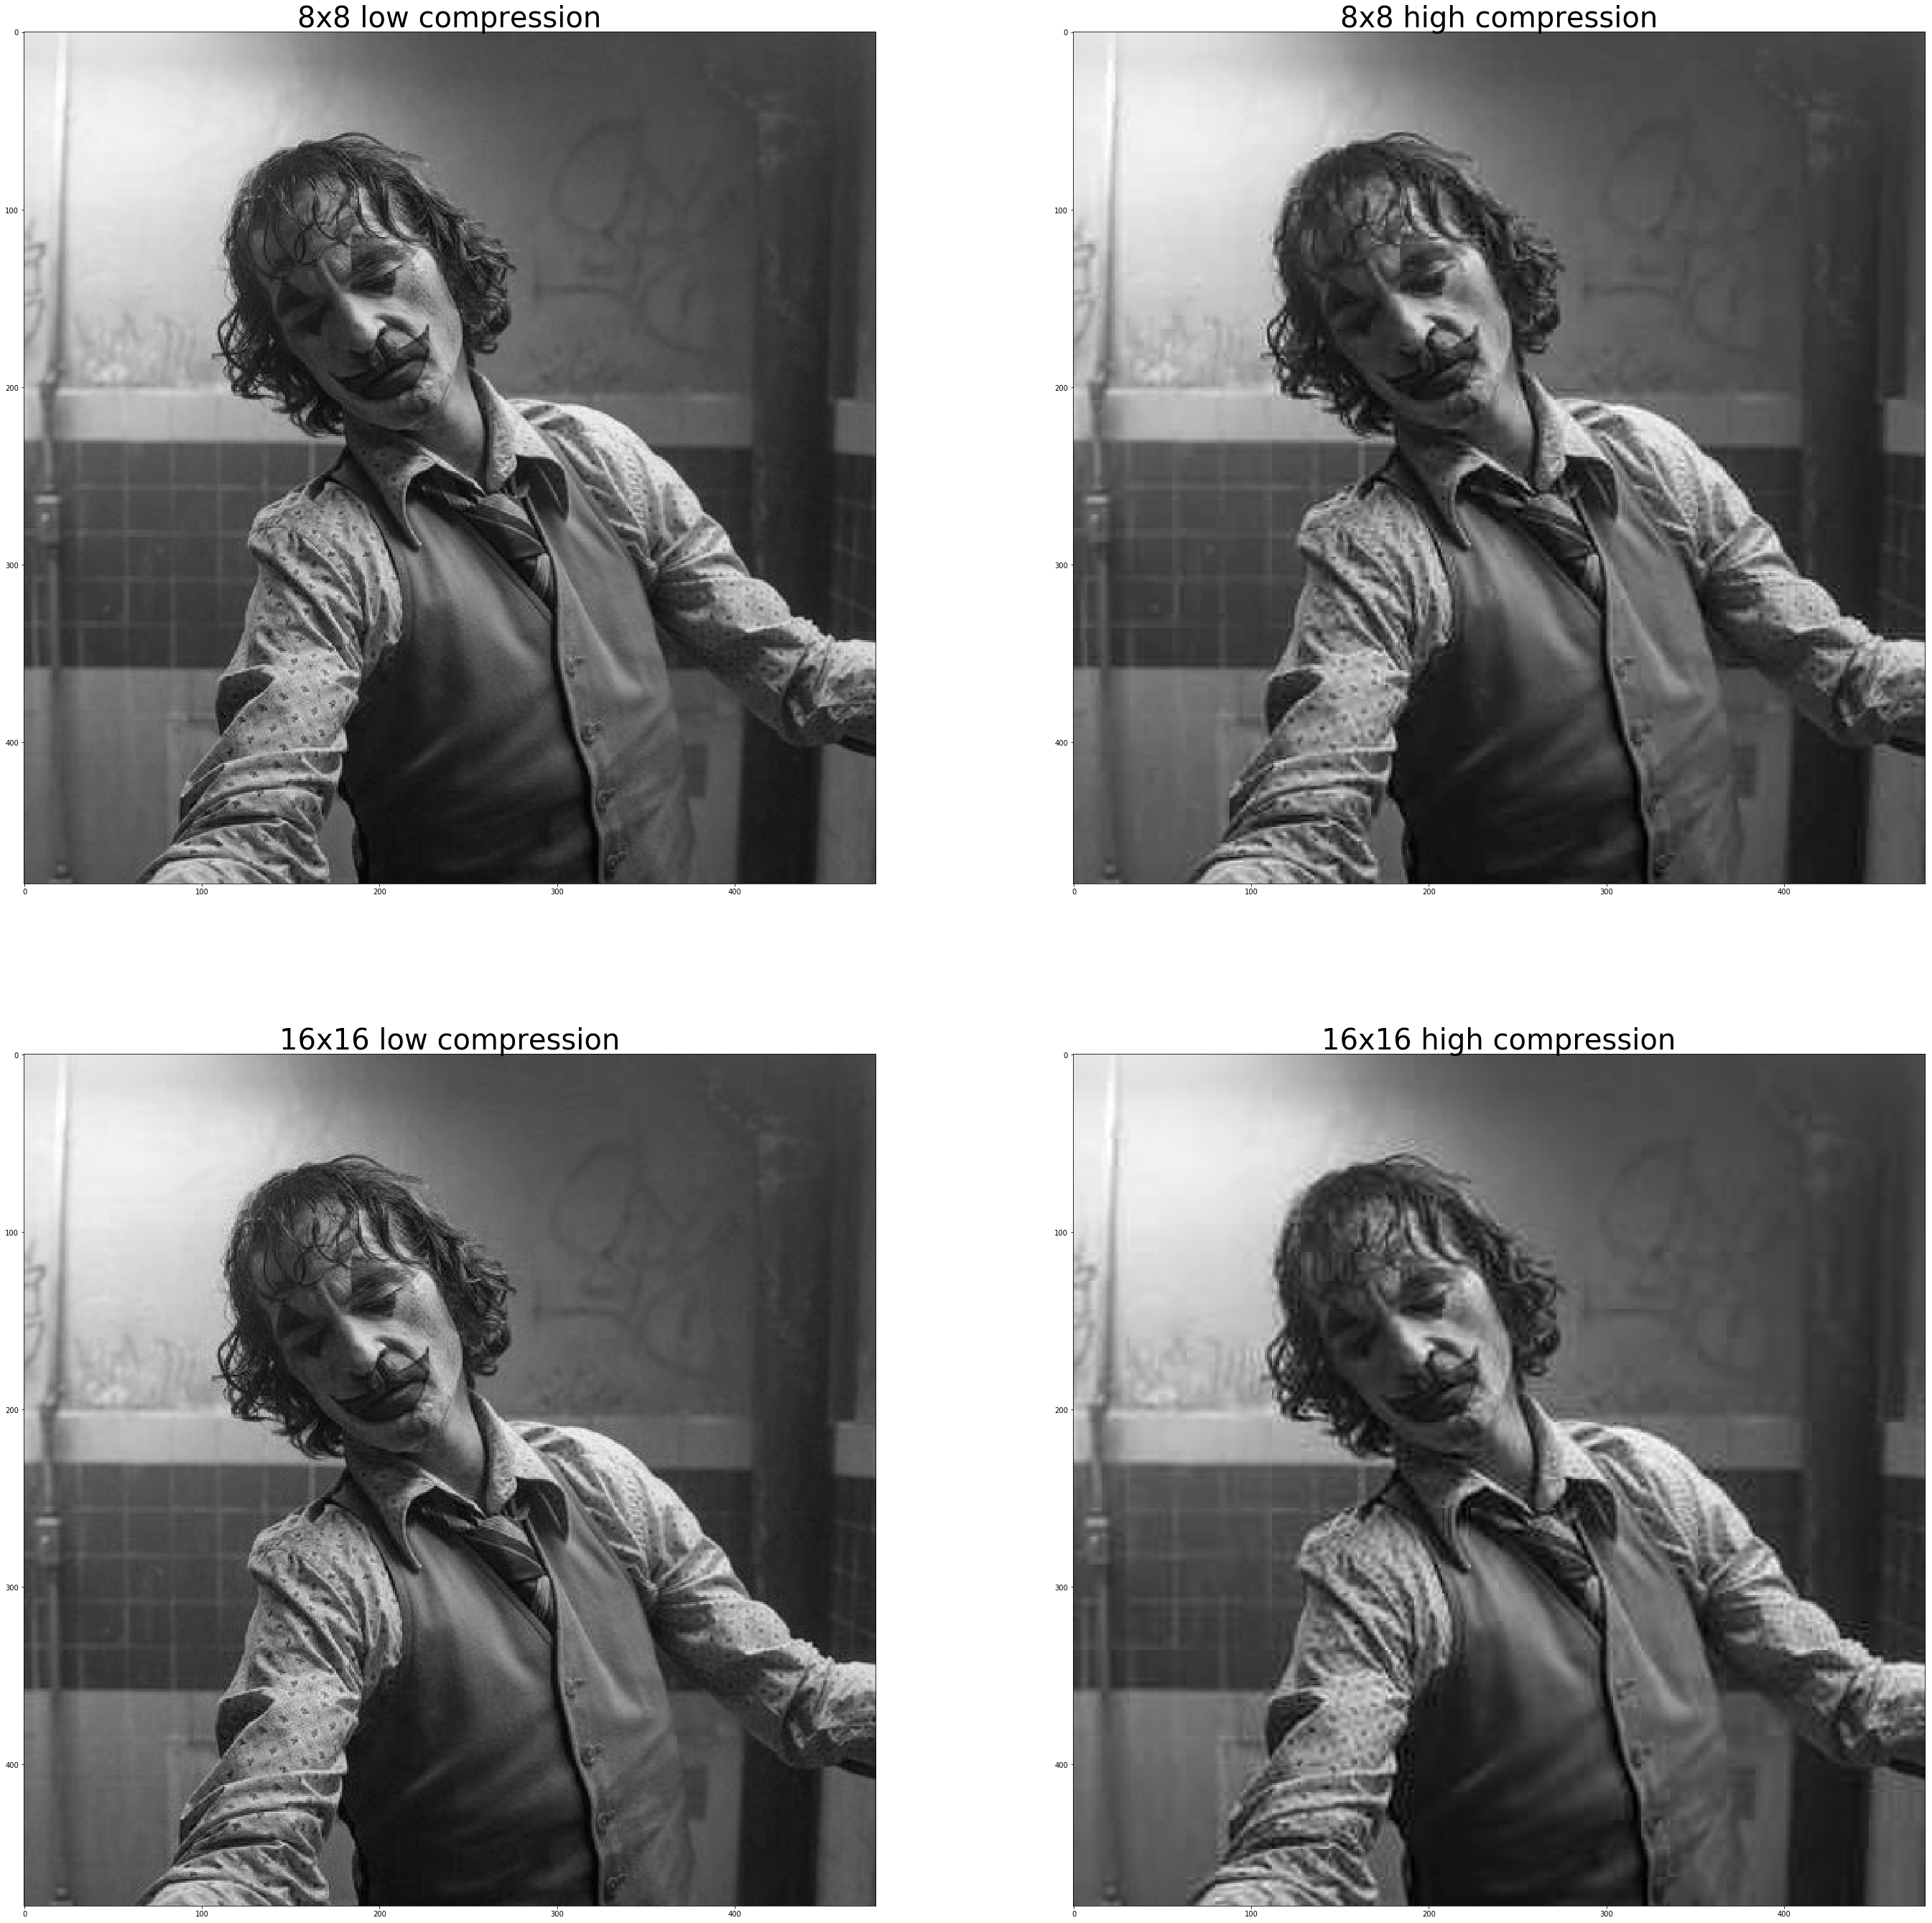

In [8]:
# Display reconstructed images
f, axarr = plt.subplots(2,2, figsize = (48,48))
axarr[0,0].imshow(reconstructed[0], cmap = "gray")
axarr[0,0].set_title("8x8 low compression", fontsize = 40)
axarr[0,1].imshow(reconstructed[1], cmap = "gray")
axarr[0,1].set_title("8x8 high compression", fontsize = 40)
axarr[1,0].imshow(reconstructed[2], cmap = "gray")
axarr[1,0].set_title("16x16 low compression", fontsize = 40)
axarr[1,1].imshow(reconstructed[3], cmap = "gray")
axarr[1,1].set_title("16x16 high compression", fontsize = 40)

### Quantitative comparison



The table below shows quantitative analysis of the resulting reconstructed images. As expected, 8x8 compression results in lower root mean squared error than 16x16 compression and lower compression ratio. This is due to the fact that less data is lost in 8x8 compression. It retains more information. Also, we can notice that the number of floating point operations is significantly lower for 16x16 compression blocks. High compression yields greater compression ratio compared to low compression in both 8x8 and 16x16 blocks. It also yields higher RMSE. This is expected since more data is lost when higher compression type is used. It corresponds to a quantization table that has large values, which zeros out all high frequency components in the image. Moreover, # of flops in high compression is almost half of that in low compression (for both 8x8 and 16x16 blocks). This is due to the fact that run-length encoding takes significantly shorter time to decode highly compressed images compared to low compressed images; there are more zeros in highly compressed images. 

In [9]:
# Amount of compression achieved
imarr = reshape_image(im)

#Compute the number of bits of the np array image
size_before = imarr.size * imarr.itemsize * 8 
print("Size in bits of image before compression: ", size_before)

# Number of bits in encoded is the length of encoded. Each element in the string corresponds to a bit in reality.

size_after = []
for i in range(len(encoded)):
    size_after.append(len(encoded[i]))

##################################################

# Number of floating point operations

#Dummy operation to measure the time for a single operation
start = timeit.default_timer()
x = 2837*3847
stop = timeit.default_timer()
single_FLOP = stop - start

##################################################


# Quality of compressed image (RMSE)

rms_error =[]
for i in range(len(reconstructed)):
    if(i > 1):
        #Then reconstructed image is based on 16x16 compression,
        #Therefore, the image should be compared with the reshaped image having
        #box_size 16
        imarr = reshape_image(im,16)
    rms_error.append(rmse(imarr, reconstructed[i]))


# Print results
comp_type = ["8x8 low", "8x8 high", "16x16 low", "16x16 high",]
# intialise data of lists.
data = {'compression type':comp_type,
        'size in bits': size_after,
        'compression ratio':[size_before/x for x in size_after] ,
        "# of flops": [t/single_FLOP for t in execution_time],
        'RMSE': rms_error}
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
print(df)

Size in bits of image before compression:  1843200
  compression type  size in bits  compression ratio     # of flops      RMSE
0          8x8 low        332961           5.535783  296771.714684  0.975136
1         8x8 high        149184          12.355212  155568.615084  4.432455
2        16x16 low        251556           7.327196  229030.105148  2.615538
3       16x16 high         87006          21.184746  148832.068208  4.788087




---


<h1 align="center"><font face = "Times New Roman">JPEG2000 compression</font></h1>


## Methodology




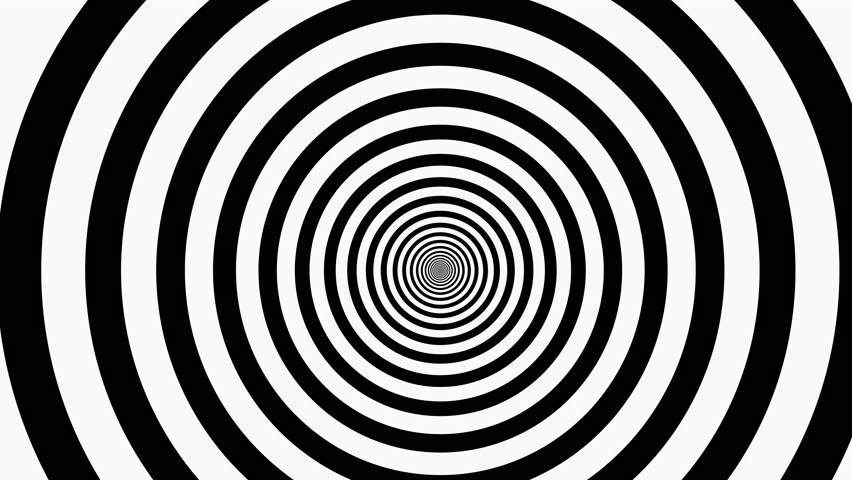

In [39]:
# Display the image

im = Image.open('images/contrast.jpg')
im = im.convert("L")
im

## breakdown of the process
JPEG2000 is yet another image compression algorithm under the category of transform compression algorithms. Similar to JPEG, JPEG2000 is also lossy and depends on giving less attention to the edges information than to illumination information. 

Similar to the analysis in the JPEG part, we repeatedly encode and decode the image according to the given decomposition levels and quantization table. The huffman encoded sequence is saved in *encoded* array to be later used in computing the compression ratio. All reconstructed images are saved in reconstructed array, and the execution time for each compression type is saved in *execution_time* array.

To encode and decode, 2 main functions in main_2000.py were utilized; namely, encode() and decode(). Both functions arrange all encoder_2000.py and decoder_2000.py functions sequentially in the following way: 

![jpeg2000 pipeline diagram](images/JPEG2000_diagram.png)

## breakdown of the process
JPEG2000 is yet another image compression algorithm under the category of transform compression algorithms. Similar to JPEG, JPEG2000 is also lossy and depends on giving less attention to the edges information than to illumination information. 

Similar to the analysis in the JPEG part, we repeatedly encode and decode the image according to the given decomposition levels and quantization table. The huffman encoded sequence is saved in *encoded* array to be later used in computing the compression ratio. All reconstructed images are saved in reconstructed array, and the execution time for each compression type is saved in *execution_time* array.

To encode and decode, 2 main functions in main_2000.py were utilized; namely, encode() and decode(). Both functions arrange all encoder_2000.py and decoder_2000.py functions sequentially in the following way: 

![jpeg2000 pipeline diagram](images/JPEG2000_diagram.png)

In [29]:
# Define quantization tables and DWT decomposition levels

# LL, LL
levels = [
             [0, #LL 
                 [[0]] #LL again
             ]
        ]

## LL block will be quantized by 2s, LH by 2s, HL by 3 and HH by 4.
quantization_Array = [1, 2, 3, 4]


encoded = [] # An array containing all 4 huffcodes resulting from the encoding process
reconstructed = [] # Array containing all 4 reconstructed images
execution_time = [] # Execution time for each compression

start = timeit.default_timer()
# Apply the the decomposition stated in levels, and perform [2,2,3,4] quantization on it. 

huffcoded, code_dict, length, aspect_ratio = m2.encode(im, levels, quantization_Array)
encoded.append(huffcoded)
reconstructed.append( m2.decode( huffcoded, code_dict, length, quantization_Array, aspect_ratio) )
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[0])


Execution time:  55.692041939000774


In [4]:
Image.fromarray(reconstructed[0]).size, im.size

((848, 480), (852, 480))

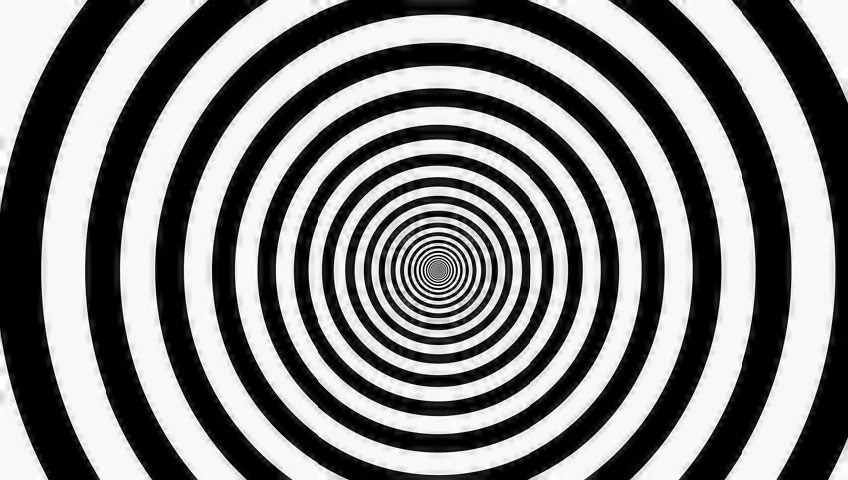

In [5]:
Image.fromarray(reconstructed[0])

In [33]:
quantization_Array = [1, 64, 128, 256]

start = timeit.default_timer() 
#LL, LL with quantization [4, 4, 5, 6]

huffcoded, code_dict, length, aspect_ratio = m2.encode(im, levels, quantization_Array)
encoded.append(huffcoded)
reconstructed.append( m2.decode( huffcoded, code_dict, length, quantization_Array, aspect_ratio) )
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[1])


Execution time:  3.1422929410000506


In [34]:
levels = [[1,[[0]]]]

## LL block will be quantized by 2s, LH by 2s, HL by 3 and HH by 4.
quantization_Array = [1, 2, 3, 4]

start = timeit.default_timer() 
# HH, LL with quantization [2,2,3,4]

huffcoded, code_dict, length, aspect_ratio = m2.encode(im, levels, quantization_Array)
encoded.append(huffcoded)
reconstructed.append( m2.decode( huffcoded, code_dict, length, quantization_Array, aspect_ratio) )
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[2])



Execution time:  73.44671262699921


In [35]:
quantization_Array = [1, 64, 128, 256]

start = timeit.default_timer() 

huffcoded, code_dict, length, aspect_ratio = m2.encode(im, levels, quantization_Array)
encoded.append(huffcoded)
reconstructed.append( m2.decode( huffcoded, code_dict, length, quantization_Array, aspect_ratio) )
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[3])



Execution time:  18.813060092999876




## Comparison
### Qualitative comparison



Here we compare between the output of 4 different runs of the algorithm alternating between 2 different decompositions and 2 different quantizations. Each image is titled with the corresponding run parameters. 

Here we compare between the output of 4 different runs of the algorithm alternating between 2 different decompositions and 2 different quantizations. Each image is titled with the corresponding run parameters. 

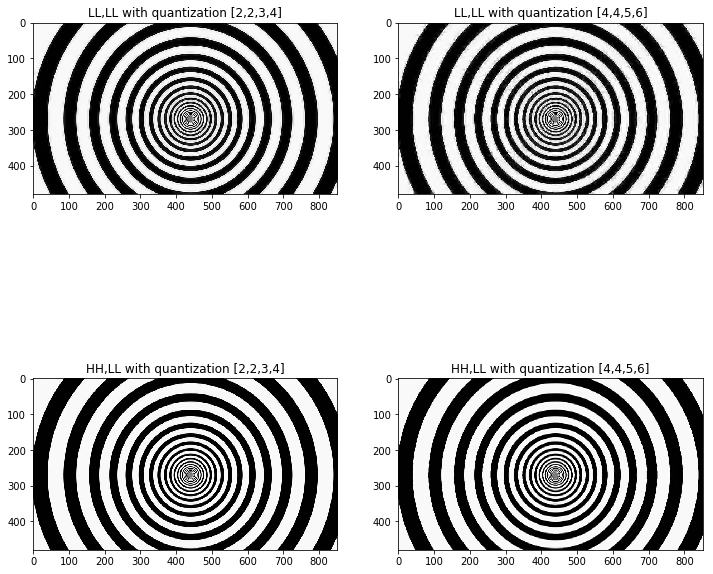

In [36]:
f, axarr = plt.subplots(2,2, figsize = (12,12))
axarr[0,0].imshow(Image.fromarray(reconstructed[0]).resize((im.size[0],im.size[1])), cmap = "gray")
axarr[0,0].set_title("LL,LL with quantization [1,2,3,4]", fontsize = 40)
axarr[0,1].imshow(Image.fromarray(reconstructed[1]).resize((im.size[0],im.size[1])), cmap = "gray")
axarr[0,1].set_title("LL,LL with quantization [1, 64, 128, 256]", fontsize = 40)
axarr[1,0].imshow(Image.fromarray(reconstructed[2]).resize((im.size[0],im.size[1])), cmap = "gray")
axarr[1,0].set_title("HH,LL with quantization [1,2,3,4]", fontsize = 40)
axarr[1,1].imshow(Image.fromarray(reconstructed[3]).resize((im.size[0],im.size[1])), cmap = "gray")
axarr[1,1].set_title("HH,LL with quantization [1, 64, 128, 256]", fontsize = 40)



### Quantitative comparison



In [39]:
# Amount of compression achieved
imarr,_ = check_image(im, 3)

#Compute the number of bits of the np array image
size_before = imarr.size * imarr.itemsize * 8 
print("Size in bits of image before compression: ", size_before)

# Number of bits in encoded is the length of encoded. Each element in the string corresponds to a bit in reality.

size_after = []
for i in range(len(encoded)):
    size_after.append(len(encoded[i]))


##################################################


# Quality of compressed image (RMSE)

rms_error =[]
for i in range(len(reconstructed)):
    if(i > 1):
        #Then reconstructed image is based on 16x16 compression,
        #Therefore, the image should be compared with the reshaped image having
        #box_size 16
        imarr = check_image(im, 3)
    rms_error.append(rmse(imarr, reconstructed[i]))


# Print results
comp_type = ["LL,LL [2,2,3,4]", "LL,LL [2, 64, 128, 256]", "HH,LL [2,2,3,4]", "HH,LL [2, 64, 128, 256]",]
# intialise data of lists.
data = {'compression type':comp_type,
        'size in bits': size_after,
        'compression ratio':[size_before/x for x in size_after] ,
        "# of flops": [t/single_FLOP for t in execution_time],
        'RMSE': rms_error}
 
# Create DataFrame
df = pd.DataFrame(data)
pd.set_option('expand_frame_repr', False)
# Print the output.
print(df)

Size in bits of image before compression:  3256320


ValueError: operands could not be broadcast together with shapes (2,) (480,848) 





---


<h2 align="center"><font face = "Times New Roman"> Division of work amongst team members</font></h2>






Alaa Roshdy

*   DCT
*   main encoder and decoder
*   Documentation for decoding functions
*   Qualitative and quantitative comparison
*   Debugging and testing

Mohamed Adham Mahrous

*   Huffman encoding and decoding
*   Runlength encoding and decoding
*   DWT filtering and dwt_serialization 
*   Documentation for encoding functions
*   Qualitative and quantitative comparison
*   Debugging and testing

Mohamed Kasem Saber

*   DCT and IDCT
*   Serialize and deserialize
*   Quantize and dequantize
*   Documentation for the above
*   Get sub_images and get_reconstructed_image

Mohamed Mostafa Hamed

*   DWT encoder and decoder
*   DWT_serialize and DWT_deserialize
*   Documentation for DWT


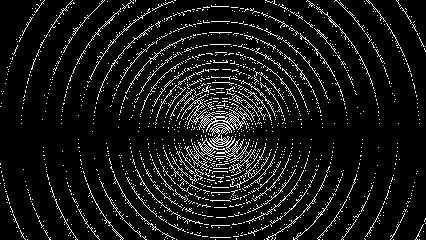

In [49]:
# LL, LL
levels = [
             [1 #LL 
             ]
        ]

## LL block will be quantized by 2s, LH by 2s, HL by 3 and HH by 4.
quantization_Array = [4, 8, 8, 8] 
    # resize image and return it as an array
def depth(l):
        if isinstance(l, int):
            return 0
        return 1 + max(iter([depth(l_rec) for l_rec in l]), default=0)
d = depth(levels)
im_arr, aspect_ratio = check_image(im, d)

 # perform dwt
filtered_image = dwt(im_arr, quantization_Array)
Image.fromarray(filtered_image[1].astype(np.uint8))


In [37]:
filtered_image[0]

array([[228, 228, 229, ...,  74,  77,  77],
       [228, 228, 229, ...,  72,  73,  75],
       [228, 228, 228, ...,  74,  74,  76],
       ...,
       [ 82,  91,  88, ...,  87,  82,  68],
       [ 82,  92,  89, ...,  85,  79,  68],
       [ 80,  90,  88, ...,  82,  74,  69]])